# 2024 CVE Data Growth Review

In [11]:
%%capture
#!rm nvd.jsonl
#!wget -q https://nvd.handsonhacking.org/nvd.jsonl

In [12]:
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import warnings
import calplot
from itables import init_notebook_mode, show
import itables.options as opt

opt.dom = "tpir"
opt.style = "table-layout:auto;width:auto"
init_notebook_mode(all_interactive=True, connected=True)

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [13]:
row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            cve = entry['cve']['id']
            try:
                assigner = entry['cve']['sourceIdentifier']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['cve']['published']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['cve']['metrics']['cvssMetricV31'][0]['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['cve']['metrics']['cvssMetricV31'][0]['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['weaknesses'][0]['description'][0]['value']
            except KeyError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['descriptions'][0]['value']
            except IndexError:
                description = ''
            try: 
                vulnStatus = entry['cve']['vulnStatus']
            except IndexError:
                vulnStatus = ''  
            new_row = {
                'CVE': cve,
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner,
                'Status': vulnStatus 
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)

nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
thisyear = ((nvd['Published'] > '2000-01-01') & (nvd['Published']  < '2025-01-01'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2000, 1, 1)
enddate  = date(2025,1,1)
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

In [14]:

Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />Average CVSS Score: **{nvd['BaseScore'].mean().round(2)}**")

Total Number of CVEs: **259214**<br />Average CVEs Per Day: **28.39**<br />Average CVSS Score: **6.92**

In [15]:
nvd['Published'] = pd.to_datetime(nvd['Published'])
Month_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
Year_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("Y")).agg('count')
Week_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("W")).agg('count')
Day_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("D")).agg('count')

#### Per Year

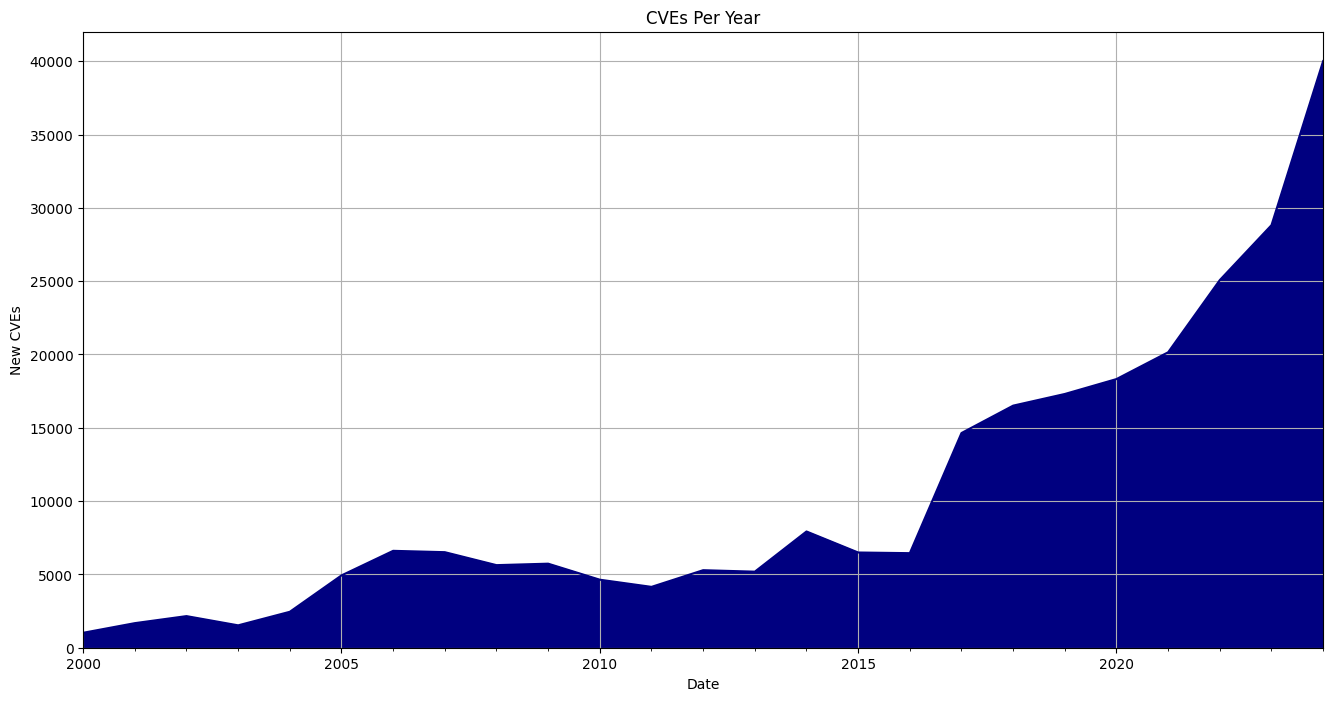

In [16]:
cg = Year_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Year')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");

In [17]:
Markdown(f"## CVE Growth Data")

## CVE Growth Data

In [18]:
yg_df = pd.DataFrame(Year_Graph)
yg_df.columns = ['Count']
yg_df = yg_df.reset_index()
yg_df['Percentage Of CVEs'] = ( yg_df['Count'] / 
                       yg_df['Count'].sum()) * 100
yg_df['Growth YOY'] = yg_df['Count'].pct_change()*100
yg_df = yg_df.round(2)
yg_df = yg_df.rename(columns={"Count": "CVEs"})
yg_df

Published   CVEs  Percentage Of CVEs  Growth YOY
0       2000   1019                0.39         NaN
1       2001   1676                0.65       64.47
2       2002   2156                0.83       28.64
3       2003   1527                0.59      -29.17
4       2004   2451                0.95       60.51
5       2005   4932                1.90      101.22
6       2006   6608                2.55       33.98
7       2007   6516                2.51       -1.39
8       2008   5632                2.17      -13.57
9       2009   5732                2.21        1.78
10      2010   4639                1.79      -19.07
11      2011   4150                1.60      -10.54
12      2012   5288                2.04       27.42
13      2013   5187                2.00       -1.91
14      2014   7928                3.06       52.84
15      2015   6494                2.51      -18.09
16      2016   6449                2.49       -0.69
17      2017  14642                5.65      127.04
18      2018  16510                6.37       12.76
19      2019  17305                6.68        4.82
20      2020  18322                7.07        5.88
21      2021  20150                7.77        9.98
22      2022  25074                9.67       24.44
23      2023  28818               11.12       14.93
24      2024  40009               15.43       38.83

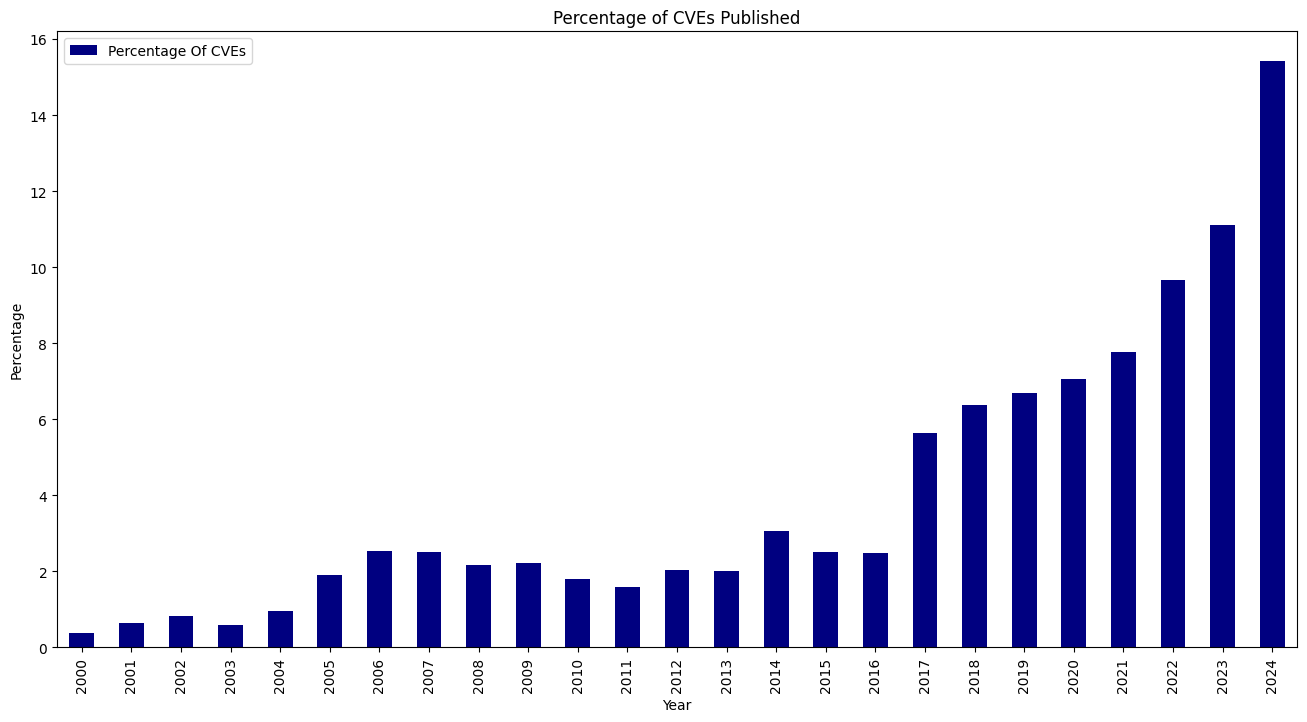

In [19]:
cg = yg_df.plot.bar(x='Published', y='Percentage Of CVEs', colormap='jet', figsize=(16, 8), title='Percentage of CVEs Published')
cg.set_ylabel("Percentage");
cg.set_xlabel("Year");

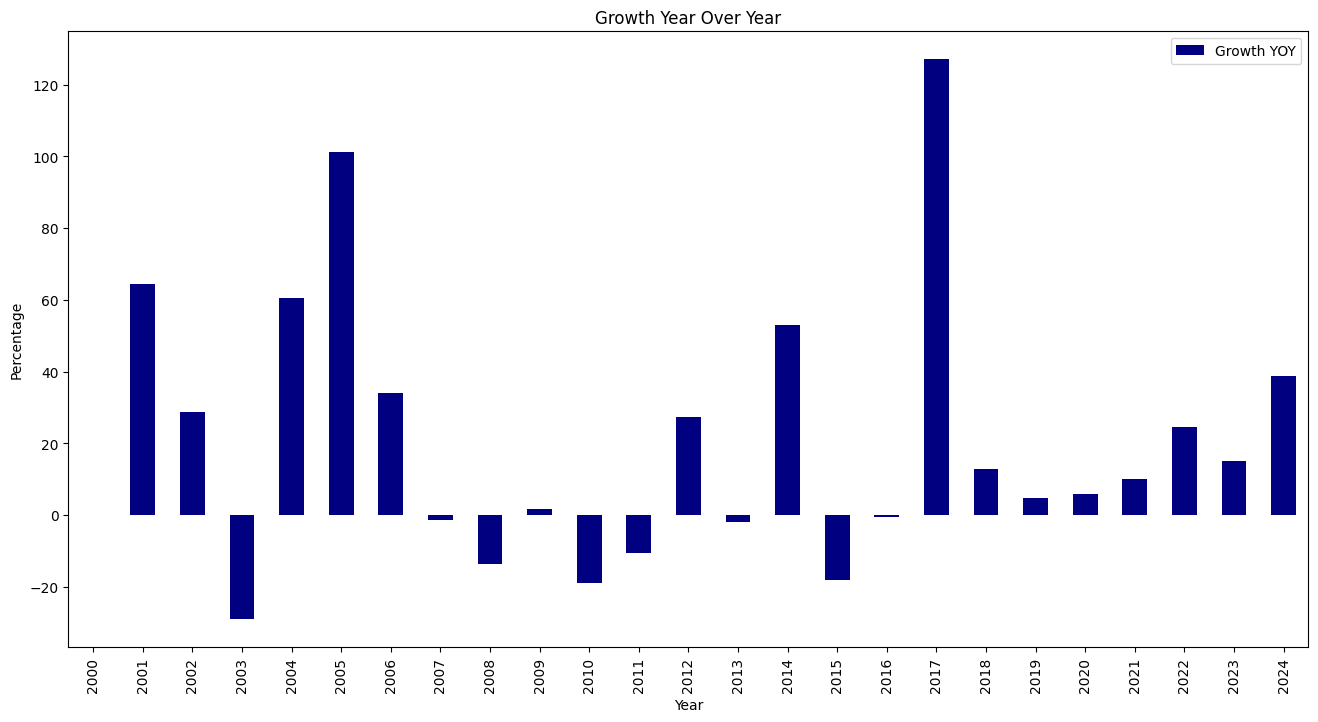

In [20]:
cg = yg_df.plot.bar(x='Published', y='Growth YOY', colormap='jet', figsize=(16, 8), title='Growth Year Over Year')
cg.set_ylabel("Percentage");
cg.set_xlabel("Year");